In [105]:
## Print multiple output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [106]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [107]:
## Pandas Display options
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)

In [108]:
match_lvl_data = pd.read_csv('match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('bowler_level_scorecard.csv')
train_data = pd.read_csv('train_data_trial_3.csv')
test_data = pd.read_csv('test_data_trial_3.csv')

In [109]:
unique_batsman_ids = batsman_lvl_data['batsman_id'].nunique()
print(unique_batsman_ids)

2118


In [110]:

match_lvl_data.shape
match_lvl_data.head(2)


(1689, 30)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0


In [111]:
batsman_lvl_data.shape
batsman_lvl_data.head(2)


(24483, 21)

,match id,batsman,batsman_id,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,over_faced_first,wicket kind,out_by_bowler,out_by_fielder,bowler_id,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt
0,8638034,KD Ce,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,7,5,1.1,caught,JS Nm,TM Jn,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,140.0,1.0,NaN,2021-01-01
1,8638034,TL St,4381761.0,NZ:Right-hand bat:None:,0.0,1.0,1,46,46,1.2,caught,R Ra,MG Bl,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,0.0,0.0,100.0,4.0,1.0,2021-01-01


In [112]:

bowler_lvl_data.shape
bowler_lvl_data.head(2)

(18539, 18)

,match id,bowler,bowler_id,bowler_details,is_bowler_captain,is_bowler_keeper,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt
0,8638034,BV Ss,6718396.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,21,0,12,10.5,0,3.0,1,1,3,1,2021-01-01
1,8638034,HK Bt,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,1,34,1,24,8.5,0,7.0,3,1,2,0,2021-01-01


In [113]:
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [114]:


train_data.shape
train_data.head(2)

(948, 48)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped,runs_consistency,strike_rate_consistency,boundary_percentage,avg_wicket_count,avg_economy,avg_maiden,avg_dots,avg_Fours,avg_Sixes,avg_wides,avg_noballs,dot_ball_percentage_ratio,wicket_to_run_ratio,avg_bowling_strike_rate
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,1.555556,1.642857,0.904734,0.791258,1.424594,2.222222,1.666667,2.000,0.333333,0.666667,0.937386,0.890493,1.039725,1.641026,0.918698,0.952020,0.811936,0.636585,1.084815,0.733951,1.050000,0.972378,1.000733,1.080726
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0,1.248227,0.593496,0.864729,0.924091,1.033629,0.890625,1.117647,1.125,1.333333,3.500000,0.985868,0.841438,0.968076,0.822430,0.973906,0.966806,0.958504,1.036431,0.990274,0.688571,1.048005,0.977765,0.996257,1.087540


In [115]:
test_data.shape
test_data.head(2)

(271, 45)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped,runs_consistency,strike_rate_consistency,boundary_percentage,avg_wicket_count,avg_economy,avg_maiden,avg_dots,avg_Fours,avg_Sixes,avg_wides,avg_noballs,dot_ball_percentage_ratio,wicket_to_run_ratio,avg_bowling_strike_rate
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN,0.166667,0.142857,0.745558,0.505515,0.126984,0.285714,1.000000,0.500,1.000000,1.000000,0.170240,0.366911,1.031621,0.045455,0.104299,0.933333,0.106870,0.250000,0.500000,0.437500,1.000000,0.711823,0.950935,0.067742
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5,0.945355,0.937984,1.062096,0.993186,0.891282,0.896104,1.090909,0.625,0.727273,1.333333,0.984319,1.190884,1.015238,0.828283,1.074122,0.989485,0.997905,1.035294,1.108978,1.110933,1.095737,1.012563,1.001180,0.912182


In [12]:
from matplotlib import pyplot as plt
plt.style.use('seaborn');
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();


In [13]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.
    
    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}
    
    Output-None
    
    Returns- dataframe having bowling/batting stats from last n games of a player before an input date. 
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'
        
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

slope: 0.6 / 0.39 =  1.53


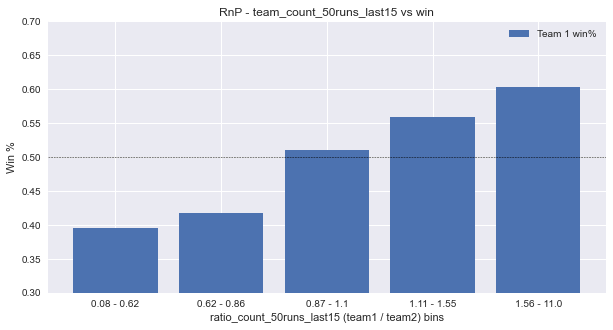

In [17]:
createRnP(train_data, 'team_count_50runs_last15')

In [20]:
def no4sLastn(player_list, date, n):
    player_list = str(player_list).split(':')
    total_fours = 0
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        total_fours += player_stats['Fours'].sum()
    return total_fours

In [21]:
# Compute features for train_data
train_data['team1_count_4runs_last15'] = train_data.progress_apply(lambda x: \
            no4sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_count_4runs_last15'] = train_data.progress_apply(lambda x: \
            no4sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team_count_4runs_last15'] = (train_data['team1_count_4runs_last15']+1)/(train_data['team2_count_4runs_last15']+1)
train_data.drop(columns=['team1_count_4runs_last15','team2_count_4runs_last15'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:18<00:00, 51.12it/s]


slope: 0.62 / 0.38 =  1.64


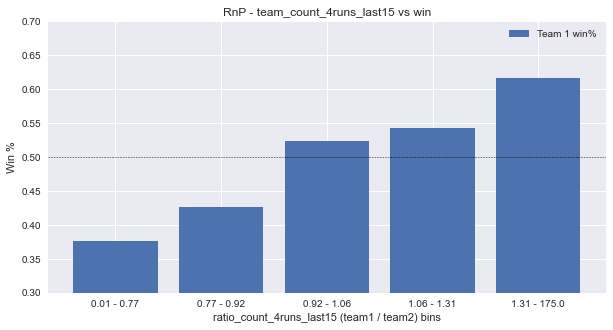

In [29]:
createRnP(train_data, 'team_count_4runs_last15')

In [28]:
def no6sLastn(player_list, date, n):
    player_list = str(player_list).split(':')
    total_sixes = 0
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        total_sixes += player_stats['Sixes'].sum()
    return total_sixes

In [30]:
train_data['team1_count_6runs_last15'] = train_data.progress_apply(lambda x: \
            no6sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_count_6runs_last15'] = train_data.progress_apply(lambda x: \
            no6sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team_count_6runs_last15'] = (train_data['team1_count_6runs_last15']+1)/(train_data['team2_count_6runs_last15']+1)
train_data.drop(columns=['team1_count_6runs_last15','team2_count_6runs_last15'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:18<00:00, 50.44it/s]


slope: 0.57 / 0.34 =  1.67


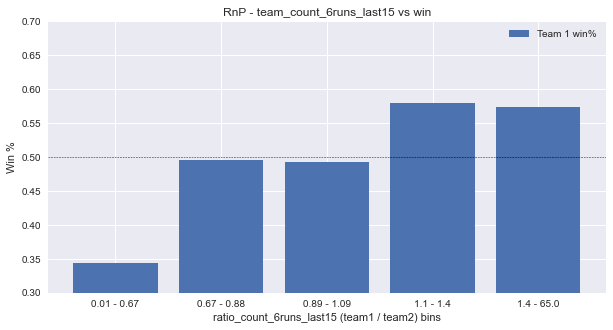

In [31]:
createRnP(train_data, 'team_count_6runs_last15')

In [33]:
# Function to get the average strike rate of players in the roster of a team in last n games
def avg_strike_rate_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    total_strike_rate = 0
    total_matches = 0
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        total_strike_rate += player_stats['strike_rate'].sum()
        total_matches += len(player_stats)
    return total_strike_rate / total_matches if total_matches > 0 else 0

In [34]:
train_data['team1_avg_strike_rate_last15'] = train_data.progress_apply(lambda x: \
            avg_strike_rate_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_strike_rate_last15'] = train_data.progress_apply(lambda x: \
            avg_strike_rate_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['avg_stkrate'] = (train_data['team1_avg_strike_rate_last15']+1)/(train_data['team2_avg_strike_rate_last15']+1)
train_data.drop(columns=['team1_avg_strike_rate_last15','team2_avg_strike_rate_last15'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:19<00:00, 49.09it/s]


slope: 0.6 / 0.37 =  1.64


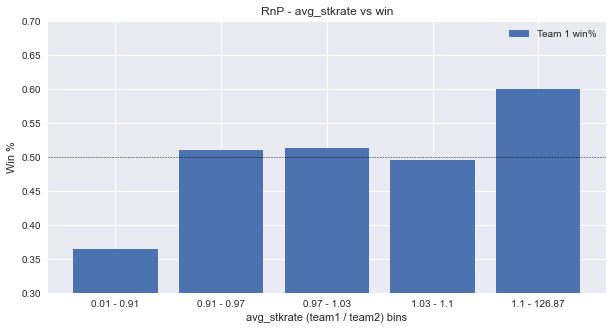

In [35]:
createRnP(train_data, 'avg_stkrate')

In [37]:
# Function to get the average runs scored by players in the roster of a team in last n games
def avg_runs_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    total_runs = 0
    total_matches = 0
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        total_runs += player_stats['runs'].sum()
        total_matches += len(player_stats)
    return total_runs / total_matches if total_matches > 0 else 0

In [38]:
train_data['team1_avg_runs_last15'] = train_data.progress_apply(lambda x: \
            avg_runs_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_runs_last15'] = train_data.progress_apply(lambda x: \
            avg_runs_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['avg_runs'] = (train_data['team1_avg_runs_last15']+1)/(train_data['team2_avg_runs_last15']+1)
train_data.drop(columns=['team1_avg_runs_last15','team2_avg_runs_last15'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:18<00:00, 50.57it/s]


slope: 0.55 / 0.46 =  1.2


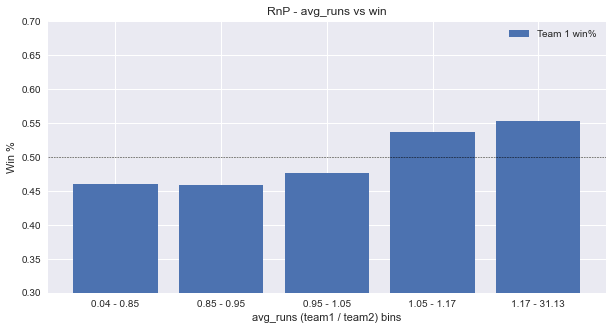

In [39]:
createRnP(train_data, 'avg_runs')

In [40]:
def avg_balls_faced_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    total_balls_faced = 0
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        total_balls_faced += player_stats['balls_faced'].sum()
    return total_balls_faced

In [41]:
train_data['team1_avg_balls_faced_last15'] = train_data.progress_apply(lambda x: \
            avg_balls_faced_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_balls_faced_last15'] = train_data.progress_apply(lambda x: \
            avg_balls_faced_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['avg_balls_faced'] = (train_data['team1_avg_balls_faced_last15']+1)/(train_data['team2_avg_balls_faced_last15']+1)
train_data.drop(columns=['team1_avg_balls_faced_last15','team2_avg_balls_faced_last15'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:18<00:00, 50.59it/s]


slope: 0.6 / 0.34 =  1.74


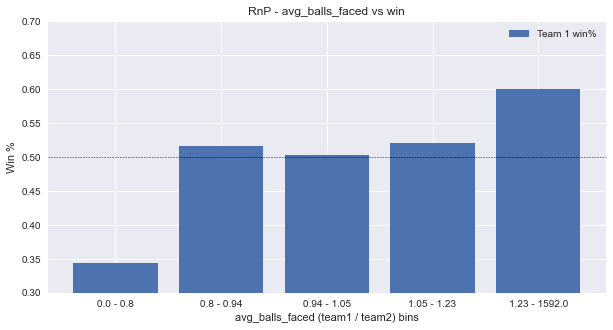

In [42]:
createRnP(train_data, 'avg_balls_faced')

In [50]:
def avg_wicket_kind_last_n_games(player_list, date, n, wicket_kind):
    player_list = str(player_list).split(':')
    total_wickets = 0
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        total_wickets += (player_stats['wicket kind'] == wicket_kind).sum()
    return total_wickets
# List of wicket kinds to compute
wicket_kinds = ['caught', 'bowled', 'lbw', 'run out', 'stumped']

In [51]:
# Compute the average count of each wicket kind for team 1 and team 2, and compute the ratio
for wicket_kind in wicket_kinds:
    train_data[f'team1_avg_{wicket_kind}_last15'] = train_data.progress_apply(lambda x: \
                avg_wicket_kind_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15, wicket_kind=wicket_kind), axis=1)
    train_data[f'team2_avg_{wicket_kind}_last15'] = train_data.progress_apply(lambda x: \
                avg_wicket_kind_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15, wicket_kind=wicket_kind), axis=1)
    
    # Taking ratio of (total wicket kind count in last 15 games for team1) to (total wicket kind count in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
    train_data[f'avg_{wicket_kind}'] = (train_data[f'team1_avg_{wicket_kind}_last15']+1)/(train_data[f'team2_avg_{wicket_kind}_last15']+1)
    train_data.drop(columns=[f'team1_avg_{wicket_kind}_last15', f'team2_avg_{wicket_kind}_last15'], inplace=True) # dropping intermediate columns


100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:19<00:00, 47.91it/s]


In [52]:
train_data.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571,1,1.555556,1.642857,0.904734,0.791258,1.424594,2.222222,1.666667,2.000000,0.333333,0.666667
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000,0,1.248227,0.593496,0.864729,0.924091,1.033629,0.890625,1.117647,1.125000,1.333333,3.500000
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,day/night match,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.0,154.333333,0,1.025381,0.786408,1.054596,1.097576,0.979472,0.757143,1.111111,0.875000,0.666667,0.200000
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,day match,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000,0,1.289308,1.702128,1.207829,1.477689,1.366240,0.880597,1.050000,0.909091,2.333333,0.333333
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,night match,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000,1,0.891304,1.258824,1.086959,0.820736,1.062331,1.129032,1.307692,1.400000,1.300000,1.500000


slope: 0.53 / 0.45 =  1.18


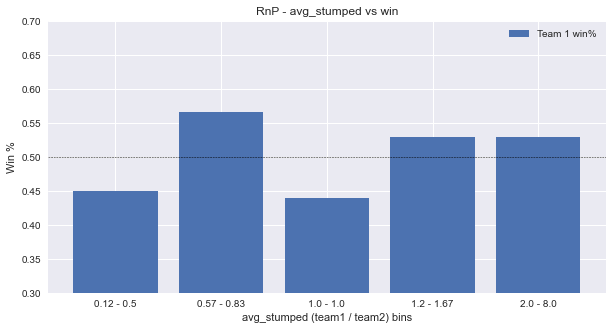

In [58]:
createRnP(train_data, 'avg_stumped')

In [61]:
# Function to get the standard deviation of runs scored by players in the roster of a team in last n games
def runs_consistency_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    all_runs = []
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        all_runs.extend(player_stats['runs'].tolist())
    return np.std(all_runs) if all_runs else 0

In [62]:
# Compute additional features for consistency and aggressiveness metrics
train_data['team1_runs_consistency_last15'] = train_data.progress_apply(lambda x: \
            runs_consistency_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_runs_consistency_last15'] = train_data.progress_apply(lambda x: \
            runs_consistency_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['runs_consistency'] = (train_data['team1_runs_consistency_last15']+1)/(train_data['team2_runs_consistency_last15']+1)
train_data.drop(columns=['team1_runs_consistency_last15','team2_runs_consistency_last15'], inplace=True)


100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:18<00:00, 51.48it/s]


slope: 0.55 / 0.43 =  1.29


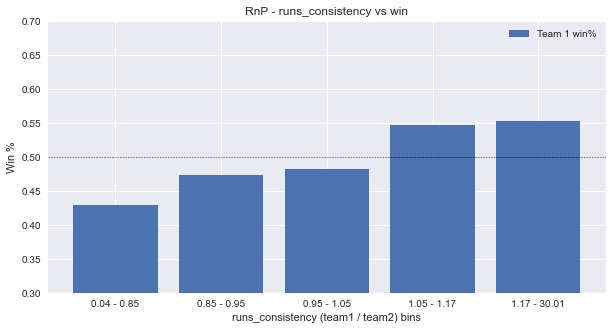

In [65]:
createRnP(train_data, 'runs_consistency')


In [63]:
# Function to get the standard deviation of strike rates of players in the roster of a team in last n games
def strike_rate_consistency_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    all_strike_rates = []
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        all_strike_rates.extend(player_stats['strike_rate'].tolist())
    return np.std(all_strike_rates) if all_strike_rates else 0

In [64]:
train_data['team1_strike_rate_consistency_last15'] = train_data.progress_apply(lambda x: \
            strike_rate_consistency_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_strike_rate_consistency_last15'] = train_data.progress_apply(lambda x: \
            strike_rate_consistency_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['strike_rate_consistency'] = (train_data['team1_strike_rate_consistency_last15']+1)/(train_data['team2_strike_rate_consistency_last15']+1)
train_data.drop(columns=['team1_strike_rate_consistency_last15','team2_strike_rate_consistency_last15'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:18<00:00, 51.20it/s]


slope: 0.52 / 0.45 =  1.15


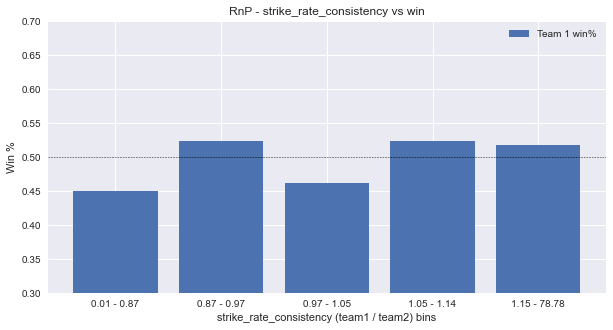

In [66]:
createRnP(train_data, 'strike_rate_consistency')

In [68]:
def boundary_percentage_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    total_runs = 0
    total_boundaries = 0
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        total_runs += player_stats['runs'].sum()
        total_boundaries += player_stats['Fours'].sum() * 4 + player_stats['Sixes'].sum() * 6
    return (total_boundaries / total_runs) if total_runs > 0 else 0

In [69]:
train_data['team1_boundary_percentage_last15'] = train_data.progress_apply(lambda x: \
            boundary_percentage_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_boundary_percentage_last15'] = train_data.progress_apply(lambda x: \
            boundary_percentage_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['boundary_percentage'] = (train_data['team1_boundary_percentage_last15']+1)/(train_data['team2_boundary_percentage_last15']+1)
train_data.drop(columns=['team1_boundary_percentage_last15','team2_boundary_percentage_last15'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:20<00:00, 46.03it/s]


slope: 0.57 / 0.4 =  1.45


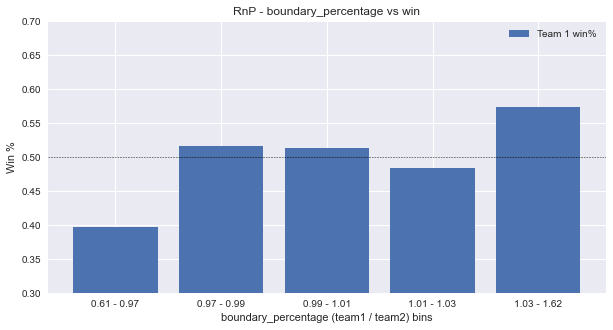

In [70]:
createRnP(train_data, 'boundary_percentage')

In [72]:
train_data.head()
train_data.shape

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped,runs_consistency,strike_rate_consistency,boundary_percentage
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571,1,1.555556,1.642857,0.904734,0.791258,1.424594,2.222222,1.666667,2.000000,0.333333,0.666667,0.937386,0.890493,1.039725
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000,0,1.248227,0.593496,0.864729,0.924091,1.033629,0.890625,1.117647,1.125000,1.333333,3.500000,0.985868,0.841438,0.968076
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,day/night match,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.0,154.333333,0,1.025381,0.786408,1.054596,1.097576,0.979472,0.757143,1.111111,0.875000,0.666667,0.200000,1.043717,0.668827,0.980600
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,day match,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000,0,1.289308,1.702128,1.207829,1.477689,1.366240,0.880597,1.050000,0.909091,2.333333,0.333333,1.198114,0.989524,0.995573
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,night match,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000,1,0.891304,1.258824,1.086959,0.820736,1.062331,1.129032,1.307692,1.400000,1.300000,1.500000,0.860648,1.349231,0.992196


(948, 37)

In [73]:
train_data.to_csv('train_data_trial_2.csv', index=False)

In [77]:
test_data.head()
test_data.shape

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped,runs_consistency,strike_rate_consistency,boundary_percentage
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN,0.166667,0.142857,0.745558,0.505515,0.126984,0.285714,1.000000,0.500000,1.000000,1.000000,0.170240,0.366911,1.031621
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.500,0.945355,0.937984,1.062096,0.993186,0.891282,0.896104,1.090909,0.625000,0.727273,1.333333,0.984319,1.190884,1.015238
2,9128776,Rn Rs,30428,8058959.0:2162782.0:2981614.0:7833195.0:7556051.0:2486896.0:184960.0:1945397.0:6420126.0:3011735.0:6347494.0,Lw Sr Gs,48334,2654014.0:2954769.0:8058903.0:3479860.0:3299407.0:2275097.0:2740408.0:3865077.0:7924048.0:4859490.0:8228100.0,Rn Rs,bat,Be Sm Mi,Mumbai,2022-05-15,night match,In Pr Le,2022,2764,0.842105,0.753086,171.066667,100.00,179.625,1.085714,1.116505,0.957993,1.049184,1.015487,1.016393,0.736842,0.545455,1.000000,1.000000,0.991207,0.902343,1.035631
3,9586919,Ja Ts,36098,4690258.0:8464385.0:1613898.0:5744780.0:3150720.0:4690104.0:1594319.0:5509524.0:2036649.0:3023383.0:5471948.0,St La Ks,36112,2331475.0:313809.0:391103.0:2742837.0:2097017.0:7921535.0:7459647.0:8464343.0:4690230.0:8339701.0:4702774.0,St La Ks,field,Dn Sy Nl Ct Sm Gs It St La,Gros Islet,2023-08-16,night match,Cn Pr Le,2023,11892,0.285714,1.487805,166.000000,75.00,155.500,0.702247,0.612069,0.864815,0.684273,0.819941,0.948276,1.214286,1.285714,0.666667,1.333333,0.726958,1.086582,0.968924
4,9128538,Ci Sr Ks,30414,7422673.0:249087.0:62432.0:232000.0:5001170.0:1642738.0:196580.0:360086.0:2022957.0:7968225.0:7879829.0,Gt Ts,48341,1958683.0:7491224.0:3339160.0:5452754.0:2252452.0:2966879.0:5554254.0:4690230.0:3456424.0:3373285.0:8118053.0,Gt Ts,field,Ma Ct An Sm Pe,Pune,2022-04-17,night match,In Pr Le,2022,18752,2.375000,0.310330,169.933333,0.00,164.125,1.534591,1.986667,1.061083,1.147404,1.306907,1.189655,1.454545,1.166667,0.727273,0.500000,1.240721,1.124739,1.056680


(271, 34)

In [76]:
# Compute features for test_data
test_data['team1_count_4runs_last15'] = test_data.progress_apply(lambda x: \
            no4sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_4runs_last15'] = test_data.progress_apply(lambda x: \
            no4sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_4runs_last15'] = (test_data['team1_count_4runs_last15']+1)/(test_data['team2_count_4runs_last15']+1)
test_data.drop(columns=['team1_count_4runs_last15','team2_count_4runs_last15'], inplace=True)

test_data['team1_count_6runs_last15'] = test_data.progress_apply(lambda x: \
            no6sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_6runs_last15'] = test_data.progress_apply(lambda x: \
            no6sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_6runs_last15'] = (test_data['team1_count_6runs_last15']+1)/(test_data['team2_count_6runs_last15']+1)
test_data.drop(columns=['team1_count_6runs_last15','team2_count_6runs_last15'], inplace=True)

test_data['team1_avg_strike_rate_last15'] = test_data.progress_apply(lambda x: \
            avg_strike_rate_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_avg_strike_rate_last15'] = test_data.progress_apply(lambda x: \
            avg_strike_rate_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['avg_stkrate'] = (test_data['team1_avg_strike_rate_last15']+1)/(test_data['team2_avg_strike_rate_last15']+1)
test_data.drop(columns=['team1_avg_strike_rate_last15','team2_avg_strike_rate_last15'], inplace=True)

test_data['team1_avg_runs_last15'] = test_data.progress_apply(lambda x: \
            avg_runs_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_avg_runs_last15'] = test_data.progress_apply(lambda x: \
            avg_runs_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['avg_runs'] = (test_data['team1_avg_runs_last15']+1)/(test_data['team2_avg_runs_last15']+1)
test_data.drop(columns=['team1_avg_runs_last15','team2_avg_runs_last15'], inplace=True)

test_data['team1_avg_balls_faced_last15'] = test_data.progress_apply(lambda x: \
            avg_balls_faced_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_avg_balls_faced_last15'] = test_data.progress_apply(lambda x: \
            avg_balls_faced_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['avg_balls_faced'] = (test_data['team1_avg_balls_faced_last15']+1)/(test_data['team2_avg_balls_faced_last15']+1)
test_data.drop(columns=['team1_avg_balls_faced_last15','team2_avg_balls_faced_last15'], inplace=True)

# Compute the average count of each wicket kind for team 1 and team 2, and compute the ratio
for wicket_kind in wicket_kinds:
    test_data[f'team1_avg_{wicket_kind}_last15'] = test_data.progress_apply(lambda x: \
                avg_wicket_kind_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15, wicket_kind=wicket_kind), axis=1)
    test_data[f'team2_avg_{wicket_kind}_last15'] = test_data.progress_apply(lambda x: \
                avg_wicket_kind_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15, wicket_kind=wicket_kind), axis=1)
    
    # Taking ratio of (total wicket kind count in last 15 games for team1) to (total wicket kind count in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
    test_data[f'avg_{wicket_kind}'] = (test_data[f'team1_avg_{wicket_kind}_last15']+1)/(test_data[f'team2_avg_{wicket_kind}_last15']+1)
    test_data.drop(columns=[f'team1_avg_{wicket_kind}_last15', f'team2_avg_{wicket_kind}_last15'], inplace=True) # dropping intermediate columns

# Compute additional features for consistency and aggressiveness metrics
test_data['team1_runs_consistency_last15'] = test_data.progress_apply(lambda x: \
            runs_consistency_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_runs_consistency_last15'] = test_data.progress_apply(lambda x: \
            runs_consistency_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['runs_consistency'] = (test_data['team1_runs_consistency_last15']+1)/(test_data['team2_runs_consistency_last15']+1)
test_data.drop(columns=['team1_runs_consistency_last15','team2_runs_consistency_last15'], inplace=True)

test_data['team1_strike_rate_consistency_last15'] = test_data.progress_apply(lambda x: \
            strike_rate_consistency_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_strike_rate_consistency_last15'] = test_data.progress_apply(lambda x: \
            strike_rate_consistency_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['strike_rate_consistency'] = (test_data['team1_strike_rate_consistency_last15']+1)/(test_data['team2_strike_rate_consistency_last15']+1)
test_data.drop(columns=['team1_strike_rate_consistency_last15','team2_strike_rate_consistency_last15'], inplace=True)

test_data['team1_boundary_percentage_last15'] = test_data.progress_apply(lambda x: \
            boundary_percentage_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_boundary_percentage_last15'] = test_data.progress_apply(lambda x: \
            boundary_percentage_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['boundary_percentage'] = (test_data['team1_boundary_percentage_last15']+1)/(test_data['team2_boundary_percentage_last15']+1)
test_data.drop(columns=['team1_boundary_percentage_last15','team2_boundary_percentage_last15'], inplace=True)


100%|███████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:05<00:00, 45.89it/s]


In [78]:
test_data.to_csv('test_data_trial_2.csv', index=False)

In [79]:
# Function to get the total number of wickets taken by players in the roster of a team in last n games
def total_wickets_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    total_wickets = 0
    for player in player_list:
        player_stats = get_last_n_games_stats(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        total_wickets += player_stats['wicket_count'].sum()
    return total_wickets

In [80]:
# Compute the avg_wicket_count for train_data
train_data['team1_wickets_last15'] = train_data.progress_apply(lambda x: total_wickets_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_wickets_last15'] = train_data.progress_apply(lambda x: total_wickets_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['avg_wicket_count'] = (train_data['team1_wickets_last15']+1)/(train_data['team2_wickets_last15']+1)
train_data.drop(columns=['team1_wickets_last15', 'team2_wickets_last15'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:16<00:00, 58.17it/s]


slope: 0.6 / 0.38 =  1.57


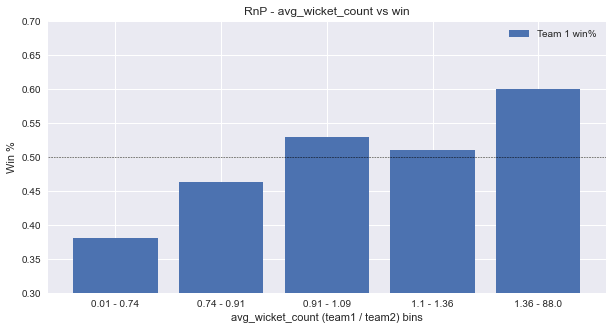

In [82]:
createRnP(train_data, 'avg_wicket_count')

In [83]:
train_data.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped,runs_consistency,strike_rate_consistency,boundary_percentage,avg_wicket_count
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571,1,1.555556,1.642857,0.904734,0.791258,1.424594,2.222222,1.666667,2.000000,0.333333,0.666667,0.937386,0.890493,1.039725,1.641026
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000,0,1.248227,0.593496,0.864729,0.924091,1.033629,0.890625,1.117647,1.125000,1.333333,3.500000,0.985868,0.841438,0.968076,0.822430
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,day/night match,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.0,154.333333,0,1.025381,0.786408,1.054596,1.097576,0.979472,0.757143,1.111111,0.875000,0.666667,0.200000,1.043717,0.668827,0.980600,1.115385
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,day match,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000,0,1.289308,1.702128,1.207829,1.477689,1.366240,0.880597,1.050000,0.909091,2.333333,0.333333,1.198114,0.989524,0.995573,0.818966
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,night match,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000,1,0.891304,1.258824,1.086959,0.820736,1.062331,1.129032,1.307692,1.400000,1.300000,1.500000,0.860648,1.349231,0.992196,1.100000


In [86]:
def avg_stat_last_n_games(player_list, date, n, stat):
    player_list = str(player_list).split(':')
    total_stat = 0
    total_matches = 0
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        total_stat += player_stats[stat].sum()
        total_matches += len(player_stats)
    return total_stat / total_matches if total_matches > 0 else 0

In [87]:
stats_to_compute = ['economy', 'maiden', 'dots', 'Fours', 'Sixes', 'wides', 'noballs']

In [88]:
for stat in stats_to_compute:
    # Compute the stat for train_data
    train_data[f'team1_avg_{stat}_last15'] = train_data.progress_apply(lambda x: avg_stat_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15, stat=stat), axis=1)
    train_data[f'team2_avg_{stat}_last15'] = train_data.progress_apply(lambda x: avg_stat_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15, stat=stat), axis=1)
    train_data[f'avg_{stat}'] = (train_data[f'team1_avg_{stat}_last15']+1) / (train_data[f'team2_avg_{stat}_last15']+1)
    train_data.drop(columns=[f'team1_avg_{stat}_last15', f'team2_avg_{stat}_last15'], inplace=True)


100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:16<00:00, 58.73it/s]


In [89]:
train_data.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped,runs_consistency,strike_rate_consistency,boundary_percentage,avg_wicket_count,avg_economy,avg_maiden,avg_dots,avg_Fours,avg_Sixes,avg_wides,avg_noballs
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571,1,1.555556,1.642857,0.904734,0.791258,1.424594,2.222222,1.666667,2.000000,0.333333,0.666667,0.937386,0.890493,1.039725,1.641026,0.918698,0.952020,0.811936,0.636585,1.084815,0.733951,1.050000
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000,0,1.248227,0.593496,0.864729,0.924091,1.033629,0.890625,1.117647,1.125000,1.333333,3.500000,0.985868,0.841438,0.968076,0.822430,0.973906,0.966806,0.958504,1.036431,0.990274,0.688571,1.048005
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,day/night match,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.0,154.333333,0,1.025381,0.786408,1.054596,1.097576,0.979472,0.757143,1.111111,0.875000,0.666667,0.200000,1.043717,0.668827,0.980600,1.115385,0.950756,1.052298,1.229018,1.030837,1.019334,1.109531,1.026316
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,day match,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000,0,1.289308,1.702128,1.207829,1.477689,1.366240,0.880597,1.050000,0.909091,2.333333,0.333333,1.198114,0.989524,0.995573,0.818966,0.972759,0.995548,1.043557,0.974138,1.002037,1.096979,1.015984
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,night match,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000,1,0.891304,1.258824,1.086959,0.820736,1.062331,1.129032,1.307692,1.400000,1.300000,1.500000,0.860648,1.349231,0.992196,1.100000,1.015838,1.044850,0.975527,1.063073,0.985306,1.022556,1.046014


In [90]:
def dot_ball_percentage_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    total_dots = 0
    total_balls = 0
    for player in player_list:
        player_stats = get_last_n_games_stats(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        total_dots += player_stats['dots'].sum()
        total_balls += player_stats['balls_bowled'].sum()
    return (total_dots / total_balls) if total_balls > 0 else 0

In [91]:
train_data['team1_dot_ball_percentage_last15'] = train_data.progress_apply(lambda x: dot_ball_percentage_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_dot_ball_percentage_last15'] = train_data.progress_apply(lambda x: dot_ball_percentage_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['dot_ball_percentage_ratio'] = (train_data['team1_dot_ball_percentage_last15']+1) / (train_data['team2_dot_ball_percentage_last15']+1)
train_data.drop(columns=['team1_dot_ball_percentage_last15', 'team2_dot_ball_percentage_last15'], inplace=True)


100%|██████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:01<00:00, 530.30it/s]


In [95]:
def wicket_to_run_ratio_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    total_wickets = 0
    total_runs = 0
    for player in player_list:
        player_stats = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        total_wickets += player_stats['wicket_count'].sum()
        total_runs += player_stats['runs'].sum()
    return (total_wickets / total_runs) if total_runs > 0 else 0

In [96]:
train_data['team1_wicket_to_run_ratio_last15'] = train_data.progress_apply(lambda x: wicket_to_run_ratio_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_wicket_to_run_ratio_last15'] = train_data.progress_apply(lambda x: wicket_to_run_ratio_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['wicket_to_run_ratio'] = (train_data['team1_wicket_to_run_ratio_last15']+1) / (train_data['team2_wicket_to_run_ratio_last15']+1)
train_data.drop(columns=['team1_wicket_to_run_ratio_last15', 'team2_wicket_to_run_ratio_last15'], inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:17<00:00, 54.22it/s]


In [97]:

def avg_bowling_strike_rate_last_n_games(player_list, date, n):
    player_list = str(player_list).split(':')
    total_wickets = 0
    total_balls = 0
    for player in player_list:
        player_stats = get_last_n_games_stats(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        total_wickets += player_stats['wicket_count'].sum()
        total_balls += player_stats['balls_bowled'].sum()
    return (total_balls / total_wickets) if total_wickets > 0 else 0

In [98]:
train_data['team1_avg_bowling_strike_rate_last15'] = train_data.progress_apply(lambda x: avg_bowling_strike_rate_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_bowling_strike_rate_last15'] = train_data.progress_apply(lambda x: avg_bowling_strike_rate_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['avg_bowling_strike_rate'] = (train_data['team1_avg_bowling_strike_rate_last15']+1) / (train_data['team2_avg_bowling_strike_rate_last15']+1)
train_data.drop(columns=['team1_avg_bowling_strike_rate_last15', 'team2_avg_bowling_strike_rate_last15'], inplace=True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:00<00:00, 1273.61it/s]


In [100]:
train_data.head()
train_data.shape

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped,runs_consistency,strike_rate_consistency,boundary_percentage,avg_wicket_count,avg_economy,avg_maiden,avg_dots,avg_Fours,avg_Sixes,avg_wides,avg_noballs,dot_ball_percentage_ratio,wicket_to_run_ratio,avg_bowling_strike_rate
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571,1,1.555556,1.642857,0.904734,0.791258,1.424594,2.222222,1.666667,2.000000,0.333333,0.666667,0.937386,0.890493,1.039725,1.641026,0.918698,0.952020,0.811936,0.636585,1.084815,0.733951,1.050000,0.972378,1.000733,1.080726
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000,0,1.248227,0.593496,0.864729,0.924091,1.033629,0.890625,1.117647,1.125000,1.333333,3.500000,0.985868,0.841438,0.968076,0.822430,0.973906,0.966806,0.958504,1.036431,0.990274,0.688571,1.048005,0.977765,0.996257,1.087540
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,day/night match,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.0,154.333333,0,1.025381,0.786408,1.054596,1.097576,0.979472,0.757143,1.111111,0.875000,0.666667,0.200000,1.043717,0.668827,0.980600,1.115385,0.950756,1.052298,1.229018,1.030837,1.019334,1.109531,1.026316,1.029208,1.003541,0.992289
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,day match,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000,0,1.289308,1.702128,1.207829,1.477689,1.366240,0.880597,1.050000,0.909091,2.333333,0.333333,1.198114,0.989524,0.995573,0.818966,0.972759,0.995548,1.043557,0.974138,1.002037,1.096979,1.015984,1.003735,1.000333,1.019218
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,night match,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000,1,0.891304,1.258824,1.086959,0.820736,1.062331,1.129032,1.307692,1.400000,1.300000,1.500000,0.860648,1.349231,0.992196,1.100000,1.015838,1.044850,0.975527,1.063073,0.985306,1.022556,1.046014,0.998965,0.994623,1.090007


(948, 48)

In [101]:
# Compute the avg_wicket_count for test_data
test_data['team1_wickets_last15'] = test_data.progress_apply(lambda x: total_wickets_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_wickets_last15'] = test_data.progress_apply(lambda x: total_wickets_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['avg_wicket_count'] = (test_data['team1_wickets_last15']+1)/(test_data['team2_wickets_last15']+1)
test_data.drop(columns=['team1_wickets_last15', 'team2_wickets_last15'], inplace=True)


for stat in stats_to_compute:
    # Compute the stat for test_data
    test_data[f'team1_avg_{stat}_last15'] = test_data.progress_apply(lambda x: avg_stat_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15, stat=stat), axis=1)
    test_data[f'team2_avg_{stat}_last15'] = test_data.progress_apply(lambda x: avg_stat_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15, stat=stat), axis=1)
    test_data[f'avg_{stat}'] = (test_data[f'team1_avg_{stat}_last15']+1) / (test_data[f'team2_avg_{stat}_last15']+1)
    test_data.drop(columns=[f'team1_avg_{stat}_last15', f'team2_avg_{stat}_last15'], inplace=True)
    

# Compute new features for test_data
test_data['team1_dot_ball_percentage_last15'] = test_data.progress_apply(lambda x: dot_ball_percentage_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_dot_ball_percentage_last15'] = test_data.progress_apply(lambda x: dot_ball_percentage_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['dot_ball_percentage_ratio'] = (test_data['team1_dot_ball_percentage_last15']+1) / (test_data['team2_dot_ball_percentage_last15']+1)
test_data.drop(columns=['team1_dot_ball_percentage_last15', 'team2_dot_ball_percentage_last15'], inplace=True)

test_data['team1_wicket_to_run_ratio_last15'] = test_data.progress_apply(lambda x: wicket_to_run_ratio_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_wicket_to_run_ratio_last15'] = test_data.progress_apply(lambda x: wicket_to_run_ratio_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['wicket_to_run_ratio'] = (test_data['team1_wicket_to_run_ratio_last15']+1) / (test_data['team2_wicket_to_run_ratio_last15']+1)
test_data.drop(columns=['team1_wicket_to_run_ratio_last15', 'team2_wicket_to_run_ratio_last15'], inplace=True)

test_data['team1_avg_bowling_strike_rate_last15'] = test_data.progress_apply(lambda x: avg_bowling_strike_rate_last_n_games(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_avg_bowling_strike_rate_last15'] = test_data.progress_apply(lambda x: avg_bowling_strike_rate_last_n_games(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['avg_bowling_strike_rate'] = (test_data['team1_avg_bowling_strike_rate_last15']+1) / (test_data['team2_avg_bowling_strike_rate_last15']+1)
test_data.drop(columns=['team1_avg_bowling_strike_rate_last15', 'team2_avg_bowling_strike_rate_last15'], inplace=True)


100%|█████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 1262.70it/s]


In [103]:
test_data.head()
test_data.shape

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped,runs_consistency,strike_rate_consistency,boundary_percentage,avg_wicket_count,avg_economy,avg_maiden,avg_dots,avg_Fours,avg_Sixes,avg_wides,avg_noballs,dot_ball_percentage_ratio,wicket_to_run_ratio,avg_bowling_strike_rate
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN,0.166667,0.142857,0.745558,0.505515,0.126984,0.285714,1.000000,0.500000,1.000000,1.000000,0.170240,0.366911,1.031621,0.045455,0.104299,0.933333,0.106870,0.250000,0.500000,0.437500,1.000000,0.711823,0.950935,0.067742
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.500,0.945355,0.937984,1.062096,0.993186,0.891282,0.896104,1.090909,0.625000,0.727273,1.333333,0.984319,1.190884,1.015238,0.828283,1.074122,0.989485,0.997905,1.035294,1.108978,1.110933,1.095737,1.012563,1.001180,0.912182
2,9128776,Rn Rs,30428,8058959.0:2162782.0:2981614.0:7833195.0:7556051.0:2486896.0:184960.0:1945397.0:6420126.0:3011735.0:6347494.0,Lw Sr Gs,48334,2654014.0:2954769.0:8058903.0:3479860.0:3299407.0:2275097.0:2740408.0:3865077.0:7924048.0:4859490.0:8228100.0,Rn Rs,bat,Be Sm Mi,Mumbai,2022-05-15,night match,In Pr Le,2022,2764,0.842105,0.753086,171.066667,100.00,179.625,1.085714,1.116505,0.957993,1.049184,1.015487,1.016393,0.736842,0.545455,1.000000,1.000000,0.991207,0.902343,1.035631,1.119266,1.051350,0.983259,1.015447,0.973749,1.074441,1.140090,1.027627,0.996399,1.003593,0.907656
3,9586919,Ja Ts,36098,4690258.0:8464385.0:1613898.0:5744780.0:3150720.0:4690104.0:1594319.0:5509524.0:2036649.0:3023383.0:5471948.0,St La Ks,36112,2331475.0:313809.0:391103.0:2742837.0:2097017.0:7921535.0:7459647.0:8464343.0:4690230.0:8339701.0:4702774.0,St La Ks,field,Dn Sy Nl Ct Sm Gs It St La,Gros Islet,2023-08-16,night match,Cn Pr Le,2023,11892,0.285714,1.487805,166.000000,75.00,155.500,0.702247,0.612069,0.864815,0.684273,0.819941,0.948276,1.214286,1.285714,0.666667,1.333333,0.726958,1.086582,0.968924,1.367647,0.912698,1.013008,1.239170,1.085366,0.987878,1.041660,0.866205,1.025141,1.012268,0.792152
4,9128538,Ci Sr Ks,30414,7422673.0:249087.0:62432.0:232000.0:5001170.0:1642738.0:196580.0:360086.0:2022957.0:7968225.0:7879829.0,Gt Ts,48341,1958683.0:7491224.0:3339160.0:5452754.0:2252452.0:2966879.0:5554254.0:4690230.0:3456424.0:3373285.0:8118053.0,Gt Ts,field,Ma Ct An Sm Pe,Pune,2022-04-17,night match,In Pr Le,2022,18752,2.375000,0.310330,169.933333,0.00,164.125,1.534591,1.986667,1.061083,1.147404,1.306907,1.189655,1.454545,1.166667,0.727273,0.500000,1.240721,1.124739,1.056680,1.123711,1.062247,1.005476,0.895499,1.002222,0.954269,1.095328,1.001163,0.972183,0.995869,1.053272


(271, 45)

In [104]:
train_data.to_csv('train_data_trial_3.csv', index=False)
test_data.to_csv('test_data_trial_3.csv', index=False)

In [121]:
## derived feature computed using toss winner & toss decision to denote the inning team1 bats.
# If team1 won the toss and chose to bat or team2 won the toss and chose to bowl, the feature takes the value 1, else 2.
match_lvl_data['team2_bat_inning'] = np.where( ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)

In [122]:
def teamAvgRunsLastn(team_id, date, n):
    df_rel = match_lvl_data[(match_lvl_data['match_dt'] < date) & 
                            ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))] \
                            .sort_values(by='match_dt', ascending=False).head(n)
    
    df_rel = pd.concat([df_rel[df_rel['team2_bat_inning'] == 1][['inning1_runs']].rename(columns={'inning1_runs': 'runs'}), 
                        df_rel[df_rel['team2_bat_inning'] == 2][['inning2_runs']].rename(columns={'inning2_runs': 'runs'})])
    
    return df_rel['runs'].mean()

In [123]:
# Compute average runs scored by team2 in their last 15 games for train data
train_data['team2only_avg_runs_last15'] = train_data.progress_apply(lambda x: 
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)

# Similarly for test data
test_data['team2only_avg_runs_last15'] = test_data.progress_apply(lambda x: 
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 281.02it/s]


In [125]:
# Create the new column 'teamonly_avg_runs_last15' by dividing 'team1only_avg_runs_last15' by 'team2only_avg_runs_last15'
train_data['teamonly_avg_runs_last15'] = train_data['team1only_avg_runs_last15'] / train_data['team2only_avg_runs_last15']
test_data['teamonly_avg_runs_last15'] = test_data['team1only_avg_runs_last15'] / test_data['team2only_avg_runs_last15']

# Drop the intermediate columns
train_data.drop(columns=['team1only_avg_runs_last15', 'team2only_avg_runs_last15'], inplace=True)
test_data.drop(columns=['team1only_avg_runs_last15', 'team2only_avg_runs_last15'], inplace=True)


In [130]:
match_lvl_data.head()

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id,team2_bat_inning,team1_bat_inning
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN,2,1
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0,2,1
2,8587837,Sy Ss,Be Ht,Be Ht,wickets,4.0,Sy Ss,bat,Be Ct Gd,Brisbane,2021-01-02,night match,Bg Bh Le,2020/21,1476,GJ Dn,PJ Ge,165,8,126,171.0,6.0,119.0,33956,7869987.0:7620283.0:2076192.0:4002340.0:3063696.0:34061.0:3200756.0:4756982.0:7455818.0:49496.0:1506077.0,33921,7620269.0:2286437.0:87191.0:5786766.0:3114803.0:2535420.0:4967738.0:3995991.0:3890984.0:7353828.0:6818776.0:5419546.0,other_domestic,33921,3890984.0,2,1
3,8638041,Nn Ds,Oo,Oo,wickets,2.0,Oo,field,By Ol,Mount Maunganui,2021-01-02,night match,Sr Sh,2020/21,17681,GA St,TJ Pe,153,7,128,156.0,8.0,126.0,17982,7907451.0:4381761.0:31464.0:4949790.0:258649.0:3834305.0:3776849.0:7543647.0:6718340.0:3566240.0:7907458.0,18360,2319638.0:256080.0:7918280.0:3913447.0:2690498.0:6129276.0:2666705.0:6317142.0:3834375.0:2236086.0:4195827.0,other_domestic,18360,NaN,2,1
4,8587921,Ht Hs,Me Ss,Ht Hs,runs,21.0,Me Ss,field,Be Ol,Hobart,2021-01-02,day/night match,Bg Bh Le,2020/21,6348,GA Ad,NR Je,164,5,126,143.0,9.0,123.0,33928,4223883.0:2161599.0:1655436.0:5788418.0:319948.0:6249256.0:2340372.0:309056.0:3125849.0:6732004.0:6722540.0,33949,363047.0:2275097.0:3901078.0:2275195.0:4230127.0:2720759.0:2337117.0:6308098.0:7877232.0:3731307.0:4985546.0:2336473.0,other_domestic,33928,3125849.0,2,1


In [129]:
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)

In [140]:
def teamAvgRunsLastn(team_id, date, n):
    df_rel = match_lvl_data[(match_lvl_data['match_dt'] < date) & 
                            ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))] \
                            .sort_values(by='match_dt', ascending=False).head(n)
    
    df_rel = pd.concat([df_rel[df_rel['team1_bat_inning'] == 1][['inning1_wickets']].rename(columns={'inning1_wickets': 'wickets'}), 
                        df_rel[df_rel['team1_bat_inning'] == 2][['inning2_wickets']].rename(columns={'inning2_wickets': 'wickets'})])
    
    return df_rel['wickets'].mean()



# Compute average runs scored by team2 in their last 15 games for train data
train_data['team2only_avg_wkt_last15'] = train_data.progress_apply(lambda x: 
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)

# Similarly for test data
test_data['team2only_avg_wkt_last15'] = test_data.progress_apply(lambda x: 
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 277.80it/s]


In [152]:
train_data.head()
test_data.shape

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_4runs_last15,team_count_6runs_last15,avg_stkrate,avg_runs,avg_balls_faced,avg_caught,avg_bowled,avg_lbw,avg_run out,avg_stumped,runs_consistency,strike_rate_consistency,boundary_percentage,avg_wicket_count,avg_economy,avg_maiden,avg_dots,avg_Fours,avg_Sixes,avg_wides,avg_noballs,dot_ball_percentage_ratio,wicket_to_run_ratio,avg_bowling_strike_rate,teamonly_avg_runs_last15,teamonly_avg_wkt_last15,teamonly_avg_amt_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,100.0,157.178571,1,1.555556,1.642857,0.904734,0.791258,1.424594,2.222222,1.666667,2.000000,0.333333,0.666667,0.937386,0.890493,1.039725,1.641026,0.918698,0.952020,0.811936,0.636585,1.084815,0.733951,1.050000,0.972378,1.000733,1.080726,1.050859,0.751220,1.114754
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,50.0,103.500000,0,1.248227,0.593496,0.864729,0.924091,1.033629,0.890625,1.117647,1.125000,1.333333,3.500000,0.985868,0.841438,0.968076,0.822430,0.973906,0.966806,0.958504,1.036431,0.990274,0.688571,1.048005,0.977765,0.996257,1.087540,1.059783,0.920000,1.833333
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,day/night match,Vy Bt,2023,251,0.857143,0.672131,0.0,154.333333,0,1.025381,0.786408,1.054596,1.097576,0.979472,0.757143,1.111111,0.875000,0.666667,0.200000,1.043717,0.668827,0.980600,1.115385,0.950756,1.052298,1.229018,1.030837,1.019334,1.109531,1.026316,1.029208,1.003541,0.992289,1.296259,0.972477,0.612903
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,day match,Cn Pr Le,2023,14300,2.166667,1.975610,50.0,144.250000,0,1.289308,1.702128,1.207829,1.477689,1.366240,0.880597,1.050000,0.909091,2.333333,0.333333,1.198114,0.989524,0.995573,0.818966,0.972759,0.995548,1.043557,0.974138,1.002037,1.096979,1.015984,1.003735,1.000333,1.019218,1.237569,1.223404,1.470000
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,night match,In Pr Le,2023,7118,0.818182,1.327869,0.0,189.000000,1,0.891304,1.258824,1.086959,0.820736,1.062331,1.129032,1.307692,1.400000,1.300000,1.500000,0.860648,1.349231,0.992196,1.100000,1.015838,1.044850,0.975527,1.063073,0.985306,1.022556,1.046014,0.998965,0.994623,1.090007,1.040674,0.921519,0.954545


(271, 47)

In [142]:
# Create the new column 'teamonly_avg_runs_last15' by dividing 'team1only_avg_runs_last15' by 'team2only_avg_runs_last15'
train_data['teamonly_avg_wkt_last15'] = train_data['team1only_avg_wkt_last15'] / train_data['team2only_avg_wkt_last15']
test_data['teamonly_avg_wkt_last15'] = test_data['team1only_avg_wkt_last15'] / test_data['team2only_avg_wkt_last15']

# Drop the intermediate columns
train_data.drop(columns=['team1only_avg_wkt_last15', 'team2only_avg_wkt_last15'], inplace=True)
test_data.drop(columns=['team1only_avg_wkt_last15', 'team2only_avg_wkt_last15'], inplace=True)

In [154]:
def teamWinAmountLastn(team_id, date, n):
    df_rel = match_lvl_data[(match_lvl_data['match_dt'] < date) & 
                                   ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))] \
                                   .sort_values(by='match_dt', ascending=False).head(n)
    
    df_rel = df_rel[df_rel['winner_id'] == team_id]
    return df_rel['win amount'].sum()

# Add columns for the win amount of team1 and team2 in their last 15 games
train_data['win_amount_team1_last15'] = train_data.progress_apply(lambda x: 
                                  teamWinAmountLastn(x['team1_id'], x['match_dt'], 15), axis=1)

train_data['win_amount_team2_last15'] = train_data.progress_apply(lambda x: 
                                  teamWinAmountLastn(x['team2_id'], x['match_dt'], 15), axis=1)

test_data['win_amount_team1_last15'] = test_data.progress_apply(lambda x: 
                                  teamWinAmountLastn(x['team1_id'], x['match_dt'], 15), axis=1)

test_data['win_amount_team2_last15'] = test_data.progress_apply(lambda x: 
                                  teamWinAmountLastn(x['team2_id'], x['match_dt'], 15), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 700.45it/s]


In [155]:
train_data['teamonly_avg_amt_last15'] = train_data.apply(
    lambda x: x['win_amount_team1_last15'] / x['win_amount_team2_last15'] if x['win_amount_team2_last15'] != 0 else 2,
    axis=1
)
test_data['teamonly_avg_amt_last15'] = test_data.apply(
    lambda x: x['win_amount_team1_last15'] / x['win_amount_team2_last15'] if x['win_amount_team2_last15'] != 0 else 2,
    axis=1
)

# Drop the intermediate columns
train_data.drop(columns=['win_amount_team1_last15', 'win_amount_team2_last15'], inplace=True)
test_data.drop(columns=['win_amount_team1_last15', 'win_amount_team2_last15'], inplace=True)

In [156]:
train_data.to_csv('train_data_trial_5.csv', index=False)
test_data.to_csv('test_data_trial_5.csv', index=False)